# G-and k distribution

Notebook for the check of gradients

### Mount Drive

In [1]:
# mount my drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


The following path has to be adjusted if necessary:

In [2]:
%run "/content/drive/My Drive/Colab Notebooks/Utils.ipynb"
%run "/content/drive/My Drive/Colab Notebooks/Plot_fcts.ipynb"

     |████████████████████████████████| 368kB 2.8MB/s 
     |████████████████████████████████| 430kB 2.9MB/s 


### Imports

In [3]:
! pip install qmcpy --quiet

In [4]:
import numpy as np
import qmcpy

from copy import deepcopy

import jax.numpy as jaxnp
from jax import jacfwd

### Sampling

In [5]:
np.random.seed(111)

Set parameters:

In [6]:
m = 1500                                  # number of simulated samples
n = 1000                                  # number of true samples
theta = np.array([3,1,1,-np.log(2)])      # true theta
d = 1                                     # dimensions of data
p = len(theta)                            # dimensions of parameter space
l = -1                                    # lengthscale (l=-1 for median heuristic)

Define QMC sequence:

In [7]:
qmc = qmcpy.Halton(d+1)

Sample from the g-and-k distribution:

In [8]:
y,_ = sample_gandk('MC',m,d,theta)
x,z = sample_gandk('MC',n,d,theta)

Plot samples and generator:

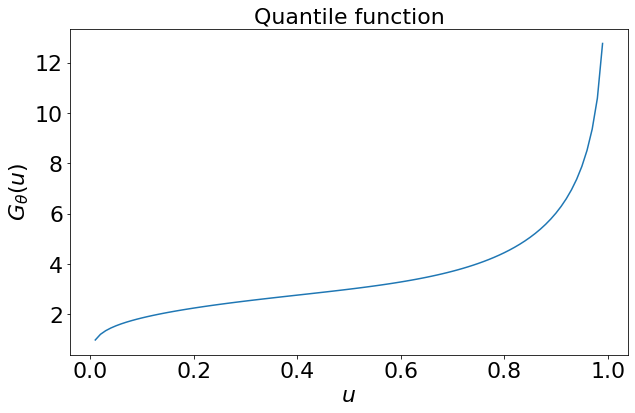

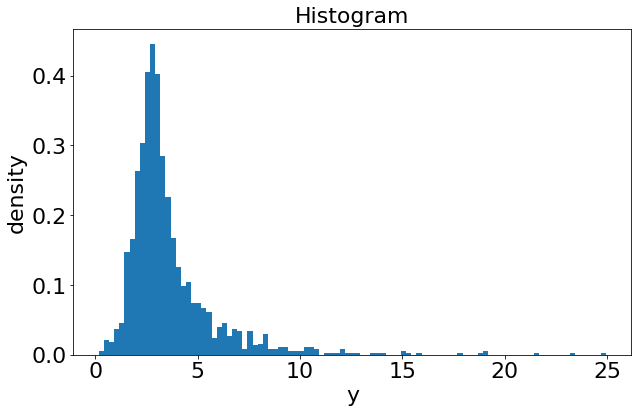

In [9]:
plot_gandk(y,(10,6),theta)

### Check generator gradient

In [10]:
print('gradient of the generator:')
grad_gen_gandk(z,theta)[:,:,0]

gradient of the generator:


array([[1.   , 0.362, 0.039, 0.033]])

In [11]:
# check gradient
def gen_test(z, theta):
    a = theta[0]
    b = theta[1]
    g = theta[2]
    k = theta[3]
    g = a+b*(1+0.8*((1-jaxnp.exp(-g*z))/(1+jaxnp.exp(-g*z))))*((1+z**2)**(k))*z
    return g
grad_test = jacfwd(gen_test,1)
theta_test = deepcopy(theta)
theta_test[3] = np.exp(theta[3])

In [12]:
print('check gradient using autodifferatiation:')
print(grad_gen_gandk(z,theta)[:,:,0])
print(grad_test(z,theta_test)[0])

check gradient using autodifferatiation:
[[1.    0.362 0.039 0.033]]


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


[[1.    0.362 0.039 0.033]]


### Check kernel

In [13]:
kxx = k(x,x,l)
kxy = k(x,y,l)
kyy = k(y,y,l)
k1xx = kxx[1]
k1xy = kxy[1]
k21xx = kxx[2]

In [14]:
print('kernel:')
print(kxy[0][1,1])
print('\nderivative w.r.t. the first element:')
print(kxy[1][:,1,1])
print('\nderivative w.r.t. the second and first element:')
print(kxy[2][:,:,1,1])

kernel:
0.9647995623568805

derivative w.r.t. the first element:
[0.258]

derivative w.r.t. the second and first element:
[[0.896]]


In [15]:
#check derivatives using finite differences
print('check first derivative w.r.t. the first element:')
print((k(x+0.00000001,y,l)[0][1,1]-kxy[0][1,1])/0.00000001)
print(np.sum(kxy[1][:,1,1]))
print('\ncheck second derivative w.r.t. the second and first element:')
print((-k(x+0.00000001,y,l)[1][:,1,1]+kxy[1][:,1,1])/0.00000001)
print(np.sum(kxy[2][:,:,1,1],axis=0))

check first derivative w.r.t. the first element:
0.2582885905155763
0.2582885975589463

check second derivative w.r.t. the second and first element:
[0.896]
[0.896]


### Check the MMD$^2$ gradient $\hat{J}$

In [16]:
print('MMD^2 approximation:')
MMD_approx(n,m,kxx[0],kxy[0],kyy[0])

MMD^2 approximation:


-0.0006662488628019214

In [17]:
grad_g = grad_gen_gandk(z, theta)
print('gradient of the MMD^2 approximation:')
grad_MMD(p,n,m,grad_g,k1xx,k1xy)

gradient of the MMD^2 approximation:


array([-0.007,  0.008, -0.002,  0.005])

In [18]:
# check gradient using finite differences
par = 2
theta_check = deepcopy(theta)
theta_check[par] = theta_check[par] + 0.00000001
x_check = gen_gandk(z,theta_check)
print('check gradient of the MMD^2 approximation:')
print((MMD_approx(n,m,k(x_check,x_check,l)[0],k(x_check,y,l)[0],kyy[0])-MMD_approx(n,m,kxx[0],kxy[0],kyy[0]))/0.00000001)
print(grad_MMD(p,n,m,grad_g,k1xx,k1xy)[par])

check gradient of the MMD^2 approximation:
-0.0016535495195313388
-0.001653618143267352


### Test information metric $g_U(\theta)$

In [19]:
# test function
print('approximation of information metric g:')
g_approx(p,n,grad_g,k21xx)

approximation of information metric g:


array([[ 0.157, -0.069,  0.01 , -0.039],
       [-0.069, -0.049, -0.024, -0.063],
       [ 0.01 , -0.024, -0.004, -0.01 ],
       [-0.039, -0.063, -0.01 , -0.098]])